In [0]:
%%capture
import os, sys
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install livelossplot


In [2]:
from google.colab import files
import torch
import time
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
import math
import numpy as np
import torchvision
from collections import Counter
from matplotlib import animation
from IPython.display import clear_output
from time import sleep

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mnist = torchvision.datasets.MNIST('data', train=True, download=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!
True
True
cu101


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


t1: 4 t2: 4 t_clutter: [4, 5, 3]


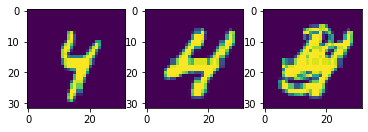

In [9]:
#load the first 5000 images of numbers from 0-9 from MNIST to a matrix and normalize them to have values between 0and 1
precomp = torch.zeros(10, 5000, 1, 28, 28).to(device)
for i in range(10):
    precomp[i] = mnist.data[mnist.targets==i][:5000].unsqueeze(1).to(device)/256.0

def make_diff(a,b):
  '''
  making sure that the randomly picked tags (e.g. 1,5,8...) in the mixture are distinct
  '''
  a = torch.stack(a)
  for i in range(len(a[0])):
    while b[i] in a[:,i]:
      b[i] += 1 
      b[i] = b[i] % 10
  return b

def get_batch(batch_size,num_clutter):
    '''
    build the inputs for the neural network
    '''
    #initiate the target and ground truth matrices
    x_target = torch.zeros(batch_size, 1, 28, 28).to(device)
    x_true = torch.zeros(batch_size, 1, 28, 28).to(device)

    # pick a tag for the target and ground truth images
    t_target = torch.randint(10, [batch_size]).to(device)
    t_true = t_target
    t_clutter = [t_true]    #the clutter/mixture must contain the ground truth

    for i in range(num_clutter):          # building the cluttered tags
      t_i = make_diff(t_clutter, torch.randint(10, [batch_size]).to(device)) #selecting number tags that are not yet in the clutter
      t_clutter.append(t_i)

    #load images into the target and true matrices
    x_target = precomp[t_target, torch.randint(5000, [batch_size])]
    x_true = precomp[t_true, torch.randint(5000, [batch_size])]

    # make sure the target and true images are not the same (pixel-wise) within a batch
    while torch.equal(x_target, x_true):
      x_true = precomp[t_true, torch.randint(5000, [batch_size])]

    x_clutter = []
    for i in t_clutter[1:]:
      x_clutter.append(precomp[i, torch.randint(5000, [batch_size])])   #loading a list of images to build the clutter from

    x_clutter_img = x_true    #ground truth must be present in the clutter
    for x_i in x_clutter:     #building the cluttered image by essentially drawing the listed images on top of each other 
      x_clutter_img = torch.max(x_clutter_img, x_i)


    # resize tensor all at once 
    x_target = torch.nn.functional.interpolate(x_target, size=32)
    x_true = torch.nn.functional.interpolate(x_true, size=32)
    x_clutter_img = torch.nn.functional.interpolate(x_clutter_img, size=32)
    return x_target, x_true, x_clutter_img,t_target,t_true,t_clutter


xtarget,xtrue,xmix,t1,t2,t3 = get_batch(5,2) #specify the batch size and the number of integers to draw on the top of the ground truth in the mixture
xtarget,xtrue,xmix = xtarget.cpu(),xtrue.cpu(),xmix.cpu()

ttarget=int(t1[0])
ttrue=int(t2[0])
tmix=[int(k[0]) for k in t3]

print('t1:',int(t1[0]),'t2:',int(t2[0]),'t_clutter:',[int(k[0]) for k in t3])

#displaying the target, ground truth, and cluttered images
fig = plt.figure()

img1 = xtarget[0][0]
fig.add_subplot(1,3,1)
plt.imshow(img1)

img2 = xtrue[0][0]
fig.add_subplot(1,3,2)
plt.imshow(img2)

clutter = xmix[0][0]
fig.add_subplot(1,3,3)
plt.imshow(clutter)

plt.show()

In [11]:
# define unet model
class UNet(nn.Module):
  
    def __init__(self, in_class=2, out_class=1):
        super().__init__()
                
        self.dconv_down1 = self.conv_block(in_class, 64)
        self.dconv_down2 = self.conv_block(64, 128)
        self.dconv_down3 = self.conv_block(128, 256)
        self.dconv_down4 = self.conv_block(256, 512)
        self.dconv_down5 = self.conv_block(512, 1024)

        self.dconv_up4 = self.conv_block(512 + 1024, 512)
        self.dconv_up3 = self.conv_block(256 + 512, 256)
        self.dconv_up2 = self.conv_block(128 + 256, 128)
        self.dconv_up1 = self.conv_block(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, out_class, 1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )
        
    def forward(self, x):
        #downsampling
        conv1 = self.dconv_down1(x) # skip-connection 1
        x = F.max_pool2d(conv1, 2)
        conv2 = self.dconv_down2(x) # skip-connection 2
        x = F.max_pool2d(conv2, 2)
        conv3 = self.dconv_down3(x) # skip-connection 3
        x = F.max_pool2d(conv3, 2)
        conv4 = self.dconv_down4(x) # skip-connection 4
        x = F.max_pool2d(conv4, 2)
        x = self.dconv_down5(x)

        #upsampling
        x = F.interpolate(x, scale_factor=2, mode='bilinear')    
        x = torch.cat([x, conv4], dim=1)  # skip-connection 4
        x = self.dconv_up4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')    
        x = torch.cat([x, conv3], dim=1)  # skip-connection 3
        x = self.dconv_up3(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat([x, conv2], dim=1)  # skip-connection 2
        x = self.dconv_up2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat([x, conv1], dim=1)  # skip-connection 1
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        
        return out

N = UNet().to(device)

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0
liveplot = PlotLosses()



> Number of network parameters 15677249


In [0]:
#model training on 100 epochs with 100 iterations
loss_list = []
max_epoch = 100
while epoch<max_epoch:
  logs = {}
  train_loss_arr = np.zeros(0)
  max_range = 100
  for i in range(max_range):
    x1,x2,xc,_,_,_ = get_batch(64,3) 
    x1,x2,xc = x1.to(device), x2.to(device), xc.to(device)
    optimiser.zero_grad()
    p = N(torch.cat((x1,xc), dim=1))  #2 class in, 1 class out
    loss = ((p-x2)**2).mean()   #mean squared error as loss function
    loss.backward()
    optimiser.step()
  
  #show results whilst training
  clear_output(wait=True)
  plt.subplot(4,1,1)
  plt.imshow(torchvision.utils.make_grid(x1[:5]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.subplot(4,1,2)
  plt.imshow(torchvision.utils.make_grid(x2[:5]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.subplot(4,1,3)
  plt.imshow(torchvision.utils.make_grid(xc[:5]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.subplot(4,1,4)
  plt.imshow(torchvision.utils.make_grid(p[:5]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.tight_layout()

  train_loss_arr = np.append(train_loss_arr, loss.cpu().data)

  liveplot.update({
        'loss': train_loss_arr.mean()
  })
  liveplot.draw()

  plt.show()
  epoch = epoch+1



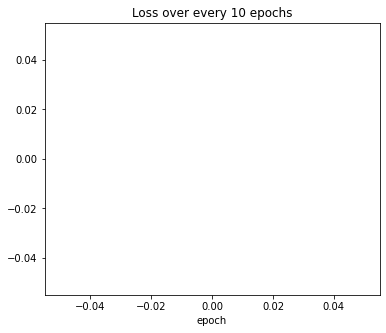

In [14]:
def plotmeanloss(loss_list,epoch_range_):
  '''
  plot the average loss over every "epoch_range_" epoch with corresponding error bars
  '''
  max_epoch = len(loss_list)
  epoch_range = [x for x in range(max_epoch) if x % epoch_range_ == 0]
  y=[]
  x=[]
  y_err=[]
  for i in range(len(epoch_range)):
    try:
      y_range = loss_list[epoch_range[i]:epoch_range[i+1]]
      y.append(np.mean(y_range))
      y_err.append(np.std(y_range))
      x.append(epoch_range[i]+epoch_range_)
    except:
      y_range = loss_list[epoch_range[i]:]
      x.append(max_epoch)
      y.append(np.mean(y_range))
      y_err.append(np.std(y_range))
  fig = plt.figure(figsize=(6,5))
  plt.title('Loss over every 10 epochs')
  plt.errorbar(x,y,y_err,0,fmt='o-',mew=2,ms=7,ecolor='gray',capsize=5,elinewidth=2)
  # plt.plot(x,y)
  plt.xlabel('epoch')


plotmeanloss(loss_list,10)